# <b>Outlier Detection </b> *✲ﾟ*｡✧٩(･ิᴗ･ิ๑)۶*✲ﾟ*｡✧

Now that we have observed some patterns in the exploration_visualization notebook, we want to investigate where the patterns are coming from. We will perform some basic statistical diagnostics like outlier detection to confirm whether the ventral/dorsal data points that are so far away from the rest are indeed outliers and if they are from the same dataset. 

In [ ]:

import helper_functions as hf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import mstats, boxcox
from sklearn.covariance import MinCovDet
import plotly.graph_objects as go



imputed_dataframe = hf.wbstruct_dataframes.loading_pkl('imputed_dataframe_2301.pkl')
truncated_dataframe = hf.wbstruct_dataframes.loading_pkl('truncated_dataframe.pkl')
dataframes = hf.wbstruct_dataframes.loading_pkl('dataframes.pkl')
turn_vec = hf.wbstruct_dataframes.loading_pkl('turn_vec.pkl')

In [ ]:
datasets = hf.wbstruct_dataframes.loading_pkl('dataframes_rebecca.pkl')
datasets.update(hf.wbstruct_dataframes.loading_pkl('dataframes_kerem.pkl'))

In univariate data, a method for outlier detection that is often used is Eucledian distance where we measure the geometric distance between an observation and the center of the data distribution. That might be problematic for multivariate data that is correlated because it might be that the observation is close to the center of the data distribution in one dimension but far away in another.

<div style="max-width:400px;margin-left: 0;">

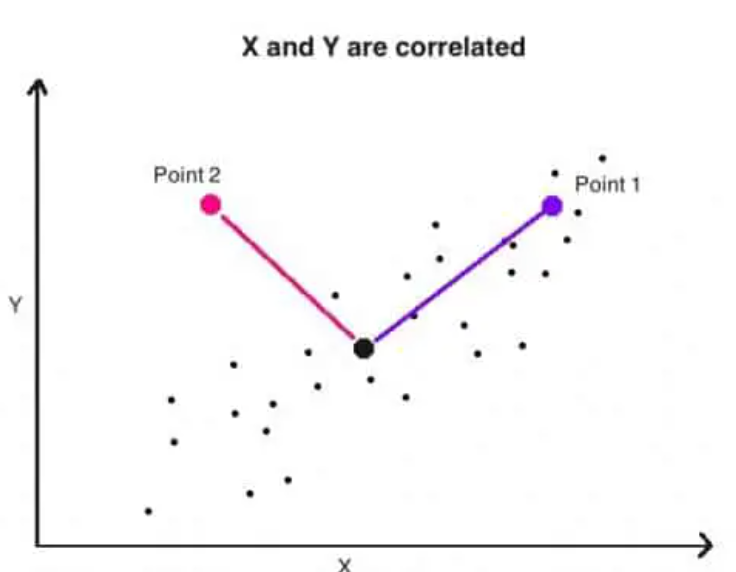

</div>
(Image from https://www.machinelearningplus.com/statistics/mahalanobis-distance/)

which is why we need a multivariate method for detecting outliers, such as the Mahalanobis distance.

### Checking for Normality
Multivariate Normality assumes that each variable individually follows a normal distribution and the relationships between variables are captured by the covariance matrix. Most analysis techniques (like MANOVA, canonical correlation analysis, LDA) for multivariate data assume normality. We will check for normality using a test where the null hypothesis is that a sample comes from a normal distribution. Additionally, we will check for normality using a Q-Q plot. 


In [ ]:
# Multivariate Normality Tests
# 1. Mardia's test
mardia_test_statistic, mardia_p_value = mstats.normaltest(imputed_dataframe)

# Visualizations
# 1. Q-Q Plot
qqplot(imputed_dataframe, line='s')
plt.title('Q-Q Plot')
plt.show()

# Print results
print(f'Mardia\'s p-value: {mardia_p_value}')


As the p-values are 0 for all the features, we can reject the null hypothesis that the data is normally distributed. This is also confirmed by the Q-Q plots. What we can do is transform the data to make it more normal. We will use the Box-Cox transformation which is a family of power transformations that are indexed by a parameter lambda. 

First we have to make sure that the data is positive. We will do this by adding the absolute value of the minimum value of the data to all the data points. Then we will apply the Box-Cox transformation to the data.

In [ ]:
feature_names2 = imputed_dataframe.columns

# Create a grid of histograms
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))
fig.suptitle('Distribution of Some Features', y=1.02)

for i, ax in enumerate(axes.flat):
    sns.histplot(imputed_dataframe, x=feature_names2[i], ax=ax)
    ax.set(title=f'Histogram of {feature_names2[i]}')

plt.tight_layout()
plt.show()

There seems to be a clear positive skew (the right tail is longer and the mass of the distribution is concentrated on the left of the figure). We will apply the Box-Cox transformation which is a family of power transformations that includes logarithmic, square root and reciprocal transformations. Box-Cox finds the optimal transformation parameter for the data and the lambda value indicates the type of transformation that is applied. lambda = 0 indicates a log transformation, lambda = 0.5 indicates a square root transformation and lambda = 1 or lambda < 0 indicates a reciprocal transformation which is 1/x. 

In [ ]:

imputed_copy = imputed_dataframe.copy()
imputed_copy = imputed_copy + abs(imputed_copy.min().min()) + 0.01
transformed_data = hf.pd.DataFrame()
all_lambdas = []
for col in imputed_copy.columns:
    transformed_data[col], best_lambda = boxcox(imputed_copy[col])
    all_lambdas.append(best_lambda)

In [ ]:
print(all_lambdas)

The Box-Cox was applied to each variable individually and looking at all 73 lambdas we notice mostly negative values which indicate a reciprocal transformation. This should unskew the data and make it more normal. We will check this by plotting the Q-Q plots again.

In [ ]:
# Multivariate Normality Tests
# 1. Mardia's test
mardia_test_statistic, mardia_p_value = mstats.normaltest(transformed_data)

# Visualizations
# 1. Q-Q Plot
qqplot(transformed_data, line='s')
plt.title('Q-Q Plot')
plt.show()

# Print results
print(f'Mardia\'s p-value: {mardia_p_value}')

In [ ]:
feature_names2 = transformed_data.iloc[:,12:].columns

# Create a grid of histograms
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 8))
fig.suptitle('Distribution of Some Features', y=1.02)

for i, ax in enumerate(axes.flat):
    sns.histplot(transformed_data.iloc[:,12:], x=feature_names2[i], ax=ax)
    ax.set(title=f'Histogram of {feature_names2[i]}')

plt.tight_layout()
plt.show()

Apparently some variables follow a normal distribution while other variables don't given that  the p-values are 0 for some variables and not for others. 
Since the transformed data still shows multivariate non-normality, we will use a robust Mahalanobis distance method on the transformed data to detect outliers.

## **Robust Mahalanobis Distances**
With the Mahalanobis distances we will compute the measure between each observation P and a distribution D. This method is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis. ([Wikipedia](https://en.wikipedia.org/wiki/Mahalanobis_distance))

In [ ]:
cov = MinCovDet(random_state=0).fit(transformed_data)

In [ ]:
t = cov.location_
C = cov.covariance_
MD2_normal = hf.get_mahalanobis_distances(transformed_data)
MD2_robust = transformed_data.apply(lambda x: np.sqrt((x-t).T @ np.linalg.inv(C) @ (x-t)), axis=1)

### Comparison of normal vs robust Mahalanobis Distances

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Plot QQ plot for the first dataset
qqplot(hf.pd.Series(MD2_normal), line='s', ax=axs[0], label='Dataset 1', marker='o', color='blue')
axs[0].set_xlabel('Theoretical Quantiles')
axs[0].set_ylabel('Sample Quantiles')
axs[0].set_title('QQ Plot - Mahalanobis Distances')

# Plot QQ plot for the second dataset
qqplot(MD2_robust, line='s', ax=axs[1], label='Dataset 2', marker='s', color='red')
axs[1].set_xlabel('Theoretical Quantiles')
axs[1].set_ylabel('Sample Quantiles')
axs[1].set_title('QQ Plot - Robust Mahalanobis Distances')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the figure
plt.show()

The extreme values that deviate from the expected line at the right end of both QQ-plots might indicate outliers. The distance at which the observations start to deviate drastically from the line seem to be between 12 and 17 for the normal distances and between 20 and 25 for the robust distances, so I would go for a threshold of 12 and 20 respectively for detecting outliers.

In [ ]:
# import pkl data
length_dict = hf.defaultdict()
for key, value in dataframes.items():
    length_dict[key] = len(value)

MD2_robust_copy = hf.pd.DataFrame(MD2_robust.copy(), columns=['MD2'])
MD2_truncated = hf.pd.DataFrame(MD2_robust.copy(), columns=['MD2'])


start_index = 0
count = 0

# we will unstack the dataframe and plot the traces for each dataset
for dataset,obs_count in length_dict.items():

    # we take the number of observations from the length dictionary and add it to the start index
    end_index = start_index + obs_count
    #MD2_truncated = np.concatenate((MD2_truncated[:start_index], MD2_truncated[start_index+100:]))
    MD2_truncated.loc[start_index:start_index+100] = np.nan
    MD2_truncated.loc[start_index:end_index,'dataset'] = dataset
    MD2_robust_copy.loc[start_index:end_index,'dataset'] = dataset
    start_index = end_index
    count += 1


In [ ]:
fig = hf.px.scatter(y=MD2_robust_copy["MD2"],x=range(len(MD2_normal)), title='Mahalanobis Distances (Robust)', labels={'x':'Observation', 'y':'MD'}, color=MD2_robust_copy["dataset"], color_continuous_scale='viridis')
fig.update_traces(marker_size=3)
fig.update_layout(legend_title='Dataset')
fig.show()

According to the (normal) Mahalanobis distances on the transformed data there are more diverging observations (delta F over F per time point) at the start of every recording (dataset). So we will work on a truncated dataset that starts at the 100th time point per recording.

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

dropped = MD2_truncated["MD2"]
dropped.dropna(inplace=True)

# Plot QQ plot for the second dataset
qqplot(dropped, line='s', ax=axs, label='Dataset 2', marker='s')
axs.set_xlabel('Theoretical Quantiles')
axs.set_ylabel('Sample Quantiles')
axs.set_title('QQ Plot - Robust Mahalanobis Distances')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
fig = hf.px.scatter(y=MD2_truncated["MD2"],x=range(len(MD2_truncated)), title='Mahalanobis Distances (Robust, first 100 frames per dataset removed)', labels={'x':'Observation', 'y':'MD'}, color=MD2_robust_copy["dataset"], color_continuous_scale='viridis')
fig.update_traces(marker_size=3)
fig.update_layout(legend_title='Dataset')
fig.add_hline(y=19, line_width=2, line_dash="dash", line_color="red")
fig.show()

Now we only have a few outliers left. The ones that seem striking are from 2 of Kerem's recordings: Dataset2_20180207_TKU862_Ctrl_w6 and Dataset3_20180112_TKU761_Ctrl_w1. But also one from Rebecca: 20210203_w3. 
We can now check which states these outliers correspond to.

In [ ]:
fig = hf.px.scatter(y=MD2_robust["MD2"],x=range(len(MD2_truncated)), title='Mahalanobis Distances (first 100 frames per dataset removed)', labels={'x':'Observation', 'y':'MD'}, color=turn_vec, color_continuous_scale='viridis')
fig.update_traces(marker_size=3)
fig.update_layout(legend_title='State')
fig.add_hline(y=20, line_width=2, line_dash="dash", line_color="red")
fig.show()

As we can see above, the main outliers are assigned to 'dorsal' and 'ventral' turn. This result coincides with our 3D plot of the principal components where a few observations falling under the 'ventral' and 'dorsal' state were far away from the rest of the data points.

### Removing Dataset2_20180207_TKU862_Ctrl_w6 with many outliers

Even though the traces of this dataset seem to look really good, we ought to remove it because it is the dataset with the most outliers.

In [ ]:
Keremremoved = imputed_dataframe.copy()
single_dataset = hf.pd.DataFrame()
single_dataset2 = hf.pd.DataFrame()
single_dataset3 = hf.pd.DataFrame()

length_dict = hf.defaultdict()
for key, value in datasets.items():
    length_dict[key] = len(value)


start_index = 0
for dataset,obs_count in length_dict.items():

    # we take the number of observations from the length dictionary and add it to the start index
    end_index = start_index + obs_count
    
    if start_index == 0:
        single_dataset3 = imputed_dataframe[start_index:end_index].copy()
    
    if obs_count == 3312:
        single_dataset2 = imputed_dataframe[start_index:end_index].copy()
    
    if obs_count == 3749:
        single_dataset = imputed_dataframe[start_index:end_index].copy()
        Keremremoved[start_index:end_index] = np.nan
    Keremremoved.loc[start_index:start_index+100] = np.nan
    start_index = end_index
    
Keremremoved = Keremremoved.dropna()
imputed_df_wooutliers = Keremremoved.copy()
turn_vec_wooutliers = hf.get_behavioural_states(imputed_df_wooutliers)
turn_vec_single = hf.get_behavioural_states(single_dataset)
turn_vec_single2 = hf.get_behavioural_states(single_dataset2)
turn_vec_single3 = hf.get_behavioural_states(single_dataset3)

In [ ]:
pca = hf.PCA(n_components=3)
imputed_pc_wooutliers = hf.pd.DataFrame(pca.fit_transform(imputed_df_wooutliers))
imputed_pc_wooutliers['state'] = turn_vec_wooutliers.values
hf.plot_PCs(imputed_pc_wooutliers,turn_vec_wooutliers,'PCA_outliers_removed.html')

### Looking at Dataset2_20180207_TKU862_Ctrl_w6 separately

In [ ]:
pca_single = hf.PCA(n_components=3)
imputed_pc_single = hf.pd.DataFrame(pca_single.fit_transform(single_dataset))
imputed_pc_single['state'] = turn_vec_single.values
hf.plot_PCs(imputed_pc_single,turn_vec_single,'PCA_single_dataset1.html')

### Looking at Control (=containing no outliers w.r.t. other data) datasets: Dataset1_20190125_ZIM1428_Ctrl_w2 

In [ ]:
pca_single2 = hf.PCA(n_components=3)
imputed_pc_single2 = hf.pd.DataFrame(pca_single2.fit_transform(single_dataset2))
imputed_pc_single2['state'] = turn_vec_single2.values
hf.plot_PCs(imputed_pc_single2,turn_vec_single2,'PCA_single_dataset2.html')

### Looking at Control (=containing no outliers w.r.t. other data) datasets: 20200629_w1  

In [ ]:
pca_single3 = hf.PCA(n_components=3)
imputed_pc_single3 = hf.pd.DataFrame(pca_single3.fit_transform(single_dataset3))
imputed_pc_single3['state'] = turn_vec_single3.values
hf.plot_PCs(imputed_pc_single3,turn_vec_single3,'PCA_single_dataset3.html')

It appears the PCA plots of the two latter datasets look worse than the PCA plot of the dataset that contains many outliers, in the sense there are no clear patterns and they seem more tangled.

### Appendix I: Thoughts on automated Behavioural State Annotation

Since there are no behavioural state annotations in the original wbstruct data from Rebecca and Kerem we applied a function (see helper_functions) that computes the state as described in the exploration_visualization notebook and the @approximate_turn_annotations_using_ids function from wbfm.
The function now assigns to an observation the state 'reversal' not only if AVAL is in the state 'high' but also in 'rise'.
Following is a plot of all 88k+ observations for the neuron RIML with a color encoding based on the state and this plot shows that there might be some errouneous state annotations. E.g. zoom in on observations 30 267, there are just a few reversals in between forward ones. 

In [ ]:
imputed_dataframe

In [ ]:
hf.px.scatter(imputed_dataframe, y="SMDVR", color=imputed_dataframe["state"], color_continuous_scale='viridis', marginal_y='histogram').show()